# Clustering


In [10]:

# Instalar librerías necesarias
!pip install datasets --quiet
!pip install pyarrow --quiet

import pandas as pd
from datasets import load_dataset

# Cargar el dataset
dataset = load_dataset("ia03/terminal-bench")
# Usamos la partición 'test' del dataset
df = pd.DataFrame(dataset["test"])
df.info()

# Crear una copia para la limpieza
df_clean = df.copy()

cols_remove = [
    "task_id",
    "archive",
    "task_yaml",
    "author_email",
    "tar_sha256",
    "generated_at",
    "tags",
    "base_description"
]

# Aplicar la eliminación de columnas
df_proc = df_clean.drop(columns=cols_remove)
print("\nColumnas restantes después de la limpieza de texto:")
print(df_proc.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   task_id                112 non-null    object
 1   archive                112 non-null    object
 2   task_yaml              112 non-null    object
 3   difficulty             112 non-null    object
 4   tags                   112 non-null    object
 5   author_email           112 non-null    object
 6   category               112 non-null    object
 7   base_description       112 non-null    object
 8   max_agent_timeout_sec  112 non-null    int64 
 9   max_test_timeout_sec   112 non-null    int64 
 10  tar_sha256             112 non-null    object
 11  archive_bytes          112 non-null    int64 
 12  n_files                112 non-null    int64 
 13  generated_at           112 non-null    object
dtypes: int64(4), object(10)
memory usage: 12.4+ KB

Columnas restantes después

In [11]:

# Codificación Ordinal para 'difficulty'
# Asignamos un orden numérico (Ordinal Encoding, ya que 'hard' es mayor que 'easy')
difficulty_map = {'easy': 1, 'medium': 2, 'hard': 3}
df_proc['difficulty_encoded'] = df_proc['difficulty'].map(difficulty_map)

# Eliminamos la columna original 'difficulty'
df_proc = df_proc.drop('difficulty', axis=1)


# 2. One-Hot Encoding para 'category'
# Esto convierte categorías nominales (categorias sin orden fijo) en columnas binarias (0 o 1)
df_proc = pd.get_dummies(df_proc, columns=['category'], drop_first=False)

df_proc.head()

,max_agent_timeout_sec,max_test_timeout_sec,archive_bytes,n_files,difficulty_encoded,category_algorithms,category_data-science,category_debugging,category_file-operations,category_file_operations,category_games,category_machine-learning,category_mathematics,category_model-training,category_personal-assistant,category_scientific-computing,category_security,category_software-engineering,category_system-administration
0,720,300,15570,7,2,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,480,60,5734,6,3,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,600,120,8667,9,2,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,900,120,9425,12,3,False,False,False,False,False,True,False,False,False,False,False,False,False,False
4,900,120,10415,23,2,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [12]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Columnas numéricas (incluyendo la dificultad codificada)
numeric_cols = [
    "max_agent_timeout_sec",
    "max_test_timeout_sec",
    "archive_bytes",
    "n_files",
    "difficulty_encoded"
]

# 1. Escalamiento de las columnas numéricas
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(df_proc[numeric_cols].values)

# 2. Extracción de las columnas One-Hot (ya están en 0 y 1, no necesitan escalar)
category_cols = [col for col in df_proc.columns if col.startswith('category_')]
matrix_category = df_proc[category_cols].values

# 3. Combinación de los datos escalados y las categorías codificadas
# Esta es la matriz 'X' final que usaremos para el clustering
X = np.hstack([numeric_scaled, matrix_category])

print(f"Matriz de datos final (X) con forma: {X.shape}")

Matriz de datos final (X) con forma: (112, 19)


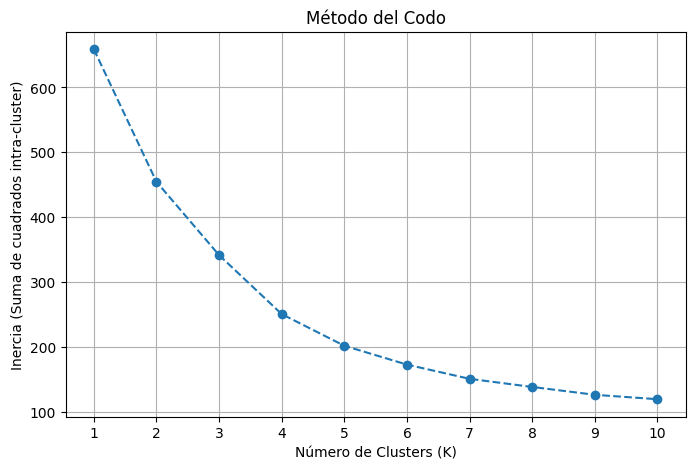

In [13]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Definir el rango de K a probar
k_range = range(1, 11)
inertia = []

# Calcular la inercia para cada valor de K
for k in k_range:

    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Graficar el Método del Codo
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia (Suma de cuadrados intra-cluster)')
plt.xticks(k_range)
plt.grid(True)
plt.show()


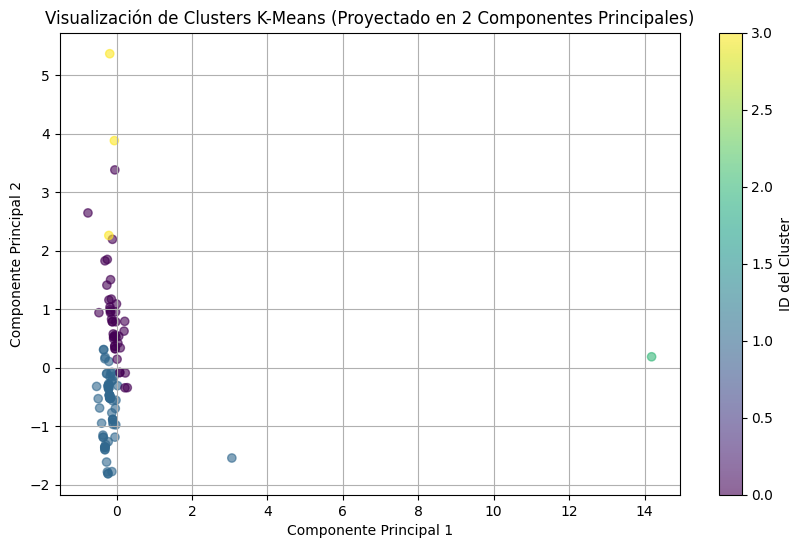

In [14]:
from sklearn.decomposition import PCA

K_OPTIMO = 4

# Entrenar el modelo final
kmeans_final = KMeans(n_clusters=K_OPTIMO, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X)

# Asignar la etiqueta de cluster al DataFrame original
df_proc["cluster"] = clusters


# 2. Visualización con PCA (Proyección de los datos a 2 dimensiones)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap="viridis", alpha=0.6)
plt.title("Visualización de Clusters K-Means (Proyectado en 2 Componentes Principales)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label='ID del Cluster')
plt.grid(True)
plt.show()


In [15]:
# Columnas a analizar (incluye las One-Hot y las métricas)
analysis_cols = numeric_cols + category_cols


# agrupar y calcular la media
cluster_profiles = df_proc.groupby("cluster")[analysis_cols].mean()

# Agregar el tamaño de cada cluster para el análisis
cluster_profiles['Count'] = df_proc['cluster'].value_counts().sort_index()

print("\nPerfiles de los Clusters (Medias de las Características):")

print(cluster_profiles)


Perfiles de los Clusters (Medias de las Características):
         max_agent_timeout_sec  max_test_timeout_sec  archive_bytes  \
cluster                                                               
0                   986.829268            148.536585   7.489310e+04   
1                  1148.358209             97.014925   4.945507e+04   
2                 86400.000000          28800.000000   4.608000e+03   
3                   720.000000            200.000000   1.157063e+07   

           n_files  difficulty_encoded  category_algorithms  \
cluster                                                       
0        10.414634            2.951220             0.000000   
1         8.432836            1.686567             0.014925   
2         6.000000            3.000000             0.000000   
3        11.000000            2.666667             0.000000   

         category_data-science  category_debugging  category_file-operations  \
cluster                                                